In [2]:
from tensorflow import keras
from keras.applications import vgg16

vgg16_model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

vgg16_model.trainable = False
vgg16_model.summary()

2022-10-14 15:11:40.862005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-14 15:11:40.870738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-14 15:11:40.871391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-14 15:11:40.871996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [3]:
from keras import layers
x = vgg16_model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=vgg16_model.input, outputs=[output_layer])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [4]:
from keras.utils import image_dataset_from_directory
import os

train_dataset = image_dataset_from_directory(
    os.path.join("..", "dataset", "cats_vs_dogs_small", "train")
)
validation_dataset = image_dataset_from_directory(
    os.path.join("..", "dataset", "cats_vs_dogs_small", "validation")
)


train_dataset = train_dataset.map(lambda x, y : (vgg16.preprocess_input(x), y))
validation_dataset = validation_dataset.map(lambda x, y : (vgg16.preprocess_input(x), y))

train_dataset

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

In [6]:
model.fit(train_dataset, batch_size=32, epochs=5, validation_data=validation_dataset)

Epoch 1/5


2022-10-14 15:11:55.164718: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-14 15:11:55.900295: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


63/63 [==============================] - 16s 155ms/step - loss: 45.9370 - binary_accuracy: 0.8755 - val_loss: 0.2170 - val_binary_accuracy: 0.9760
Epoch 2/5
63/63 [==============================] - 7s 116ms/step - loss: 0.4182 - binary_accuracy: 0.9770 - val_loss: 0.3780 - val_binary_accuracy: 0.9770
Epoch 3/5
63/63 [==============================] - 7s 111ms/step - loss: 0.1094 - binary_accuracy: 0.9905 - val_loss: 0.6029 - val_binary_accuracy: 0.9580
Epoch 4/5
63/63 [==============================] - 7s 113ms/step - loss: 0.1074 - binary_accuracy: 0.9935 - val_loss: 0.4041 - val_binary_accuracy: 0.9730
Epoch 5/5
63/63 [==============================] - 7s 112ms/step - loss: 0.1917 - binary_accuracy: 0.9895 - val_loss: 0.7629 - val_binary_accuracy: 0.9740


In [7]:
hidden_layers = []
for layer in model.layers:
    if isinstance(layer, layers.MaxPooling2D):
        hidden_layers.append(layer.output)

hidden_layers

[<KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,
 <KerasTensor: shape=(None, 16, 16, 512) dtype=float32 (created by layer 'block4_pool')>,
 <KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>]

In [11]:
test_model = keras.Model(inputs=model.input, outputs=hidden_layers)
test_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [14]:
from PIL import Image

image = Image.open("../dataset/cats_vs_dogs_small/train/cat/cat.0.jpg").resize((256, 256))
import numpy as np

image_array = np.array(image)
image_array.shape

(256, 256, 3)

In [16]:

preprocessed_image_array = vgg16.preprocess_input(image_array[np.newaxis, ...])
preprocessed_image_array.shape

(1, 256, 256, 3)

1/1 [==============================] - 0s 32ms/step


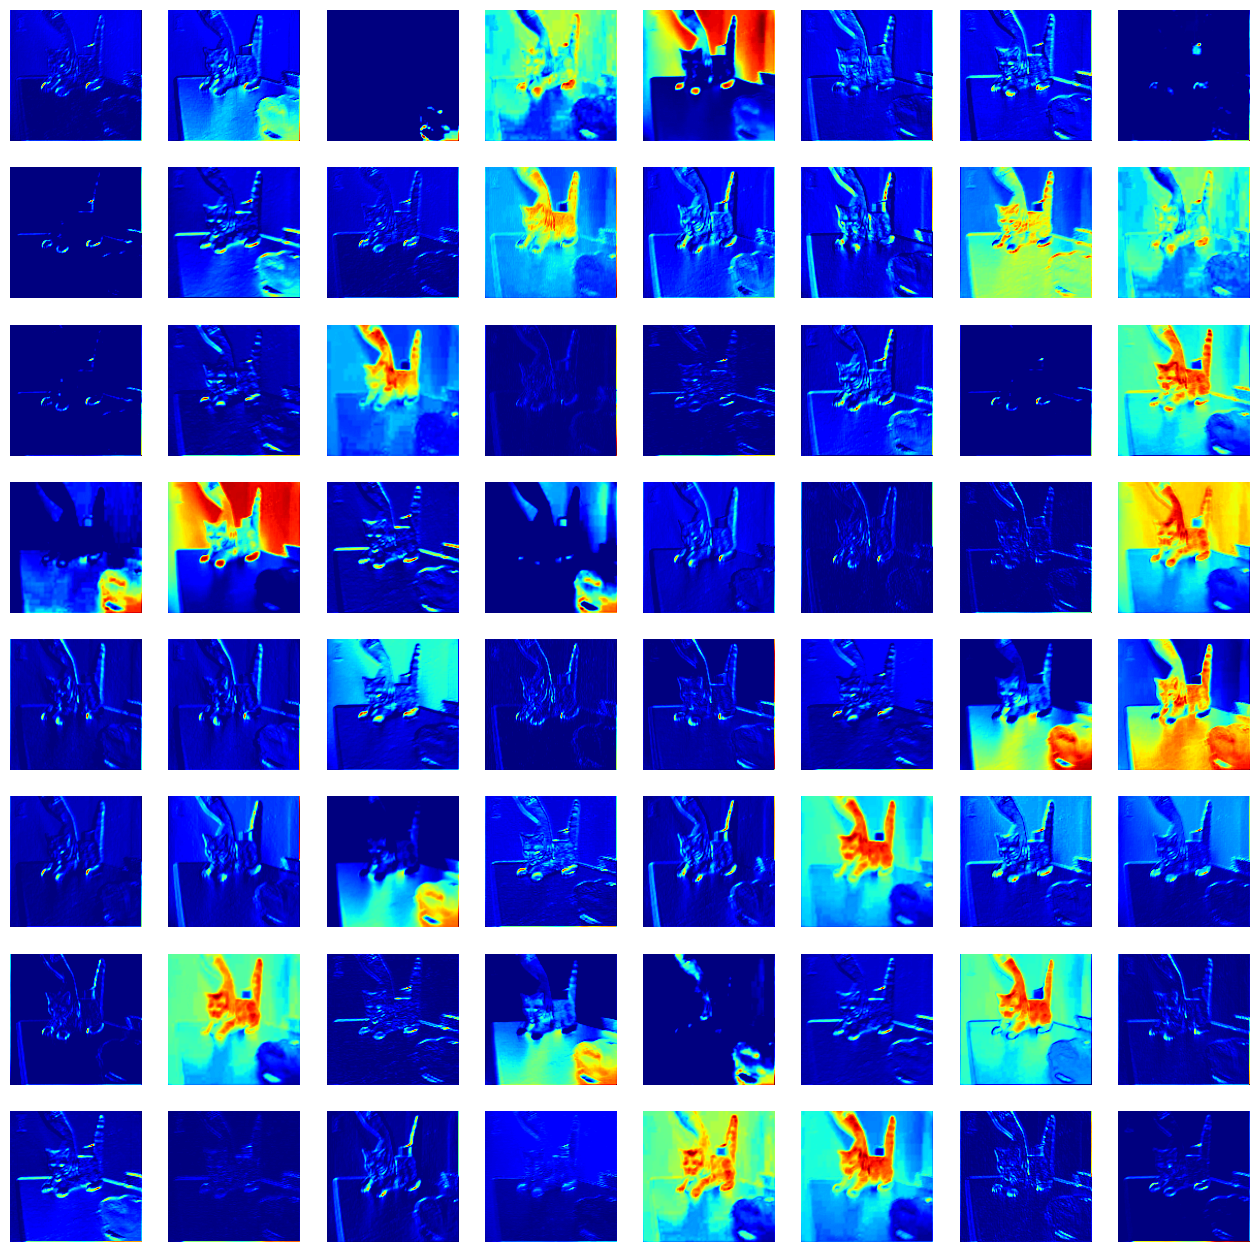

In [38]:

predicted_array = test_model.predict(preprocessed_image_array)


import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
for i in range(predicted_array[0].shape[-1]):
    ax = plt.subplot(8, 8, i+1)
    plt.imshow(predicted_array[0][0, :, :, i], cmap="jet")
    plt.axis('off')